# Proccessing, analysis, and visualization pipeline for event-related local field potential electrophysiology data
## The goal of this pipeline is to create group-level peri-event heatplots for LFP data from 2 groups (experimental and control), then collapse the data into power spectral density plots for the power change related to event timing, and finally extract the power change at the event-specific frequency (e.g. stimulation frequency) for straightforward comparisons of group-level effects
## Designed for data batch pre-processed in Neuroexplorer using the "Striatum-Batch-MUA_PSD_LFP.py" script to apply the "FirstPulses.ntp", "LFPSPEC_Final.ntp", "LFPTIMEPSD_Final.ntp", and "MUAPEH2.ntp" templates to raw data 

In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
import pynit as pn #to handle BIDS-style data organization
import os
import pandas as pd
import matplotlib.patches as patches
import matplotlib.ticker as ticker
import numpy as np
from pandas import DataFrame, date_range, datetime, read_csv
from matplotlib import pyplot, colors, rcParams 
from datetime import timedelta  
from numpy import NaN, asarray
from math import isnan
import seaborn as sns

rcParams['figure.dpi'] = 300
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Liberation Sans']

import warnings
warnings.filterwarnings("ignore")

# LFP Heatmap and color bar plotting helper function

In [7]:
def heatmapcb(df, add_plot=None, figsize=None, xlim=None, ylim=None, xlabel=None, ylabel=None,
              label_size=None, tick_size=None, title=None, title_size=None, x_ticks = 100, y_ticks = 11, z_bins = 6,
              vmin = -20, vmax = 20, cbar_kw={}, **kwargs):
        """

        :param df:
        :param figsize:
        :param xlim:
        :param ylim:
        :param xlabel:
        :param ylabel:
        :param label_size:
        :param tick_size:
        :param title:
        :param title_size:
        :param err: 0 = standard deviation, 1 = standard error
        :param kwargs:
        :return:
        """
        if not add_plot:
            fig, axes = plt.subplots(1,1,figsize=figsize)
        else:
            fig, axes = add_plot
          
        fig.patch.set_facecolor('white')
        axes.spines['top'].set_visible(False)
        axes.spines['right'].set_visible(False)
        for axis in ['top','bottom','left','right']:
              axes.spines[axis].set_linewidth(5)
        if xlim:
            axes.set_xlim(xlim)
        if ylim:
            axes.set_ylim(ylim)
        if title:
            axes.set_title(title, size=title_size)
        if xlabel:
            axes.set_xlabel(xlabel, size=label_size)
        else:
            axes.set_xlabel('Time (s)', size=label_size)
        if ylabel:
            axes.set_ylabel(ylabel, size=label_size)
        else:
            axes.set_ylabel('Responses', size=label_size)

        tlen = int(tick_size/5)
        
        axes.tick_params(labelsize=tick_size, direction='out', top='off', right='off', width = 5, length = tlen)
        
        axes.set_xlim(right = df.shape[1])
        axes.set_ylim(top = df.shape[0])
        
        axes.yaxis.set_major_locator(ticker.MultipleLocator(y_ticks))
        axes.xaxis.set_major_locator(ticker.MultipleLocator(x_ticks))
        
        axes.xaxis.set_major_formatter(FuncFormatter(numfmtx))
        axes.yaxis.set_major_formatter(FuncFormatter(numfmt)) 
        
        cmap= axes.imshow(df, cmap = 'viridis', aspect = 'auto', interpolation = 'none', origin = 'lower', resample = False,
                          vmin = vmin, vmax = vmax, **kwargs)    
        
        box = axes.get_position()
        axes.set_position([box.x0*1.05, box.y0, box.width, box.height])
        cax = plt.axes([box.x0*1.05 + box.width * 1.05, box.y0, 0.05, box.height])
        
        colorbar_format = '% .0f'
        cbar= plt.colorbar(cmap,cax=cax, format =colorbar_format)

        cbar.set_ticks(np.linspace(vmin,vmax,z_bins).astype(int))

        cbar.set_label('Power (dB)', fontsize = label_size, rotation = 270, labelpad = 65)
        cbar.ax.tick_params(labelsize=tick_size, pad = -5, direction='out', top='off', bottom='off', left='off', right='off', width = 5, length = tlen)
        
    
        cbar.outline.set_visible(False)
       
        return fig, axes

# load BIDS format project object from parent directory
## This should point to project in a \project\subproject\group\dtype\ directory organization

In [1]:
prj = pn.Project('project-folder-path') # load project object
prj.reload() # reload all updates
prj(2, ext=['.xlsx']).summary

# function to get group-level data from project object
## in this version, the data is cut and concatenated from Neuroexplorer output format (grouped by recording channel) to match a time (window for individual events) by frequency format more suitable for plotting group-level measurements from a dataframe object

In [5]:
def get_data(prj, group, cond, dshape):
    new_prj = prj(2, 'subproject-folder-name', group, cond, ext='.xlsx')
    df = pd.DataFrame()
    c = 0
    for f, finfo in new_prj:
        try:
            dff = pd.read_excel(finfo.Abspath, index_col = None).dropna()
            chunk_size = int(dff.shape[1] / dshape)
            for start in range(0, dff.shape[1], chunk_size):
                dff_subset = dff.iloc[:,start:start + chunk_size]
                dff_subset=dff_subset.reset_index(drop = True)
                dff_subset.columns = range(dff_subset.shape[1])
                df = df.add(dff_subset, fill_value=0)
                c = c + 1

        except:
            break

    print "Data from " + c + "epochs"
    df = df/c
    return df

# Peri-event heatplot and color bar plotting function for 2 conditions (experimental and control)

In [6]:
def plot_data(prj, group, first_cond = 'ChR2', second_cond = 'eYFP', Cxls= None, Exls= None, dshape = 16, figsize=[7.5,7.5], label_size=60, err=1, title_size=60, ylim = [-5,15],
              tick_size=50, ylabel='Freq. (Hz)', xlabel='Time (s)', y_ticks = 11, z_bins = 6, x_ticks = 100,
              linewidth = 5, fstart=18,fend = 98, vmin = -20, vmax = 20):
                    
    if Cxls:
        data_ChR2=pd.ExcelFile(Cxls)
        data_ChR2=pd.ExcelFile.parse(data_ChR2, header = None, index_col = None)
        data_ChR2=data_ChR2.values
    else:
        data_G = get_data(prj, group, first_cond, dshape)
        data_ChR2=data_G.reset_index(drop = True)
        data_ChR2.to_excel('{}_{}.xlsx'.format(group, first_cond), index = None, header = None)
    if Exls:
        data_eYFP=pd.ExcelFile(Exls)
        data_eYFP=pd.ExcelFile.parse(data_eYFP, header = None, index_col = None)
        data_eYFP=data_eYFP.values
    else:
        data_HbT = get_data(prj, group, second_cond, dshape)
        data_eYFP=data_HbT.reset_index(drop = True)
        data_eYFP.to_excel('{}_{}.xlsx'.format(group, second_cond), index = None, header = None)
        
    print "Condition 1 power range: " + data_ChR2.min().min() + " to " + data_ChR2.max().max()

          
    a1 = heatmapcb(data_ChR2, figsize=figsize,label_size=label_size, title_size=title_size, tick_size=tick_size,
                 ylabel= ylabel, xlabel=xlabel, y_ticks = y_ticks, z_bins = z_bins, x_ticks = x_ticks, vmin = vmin, vmax = vmax)
    a2 = heatmapcb(data_eYFP, figsize=figsize,label_size=label_size, title_size=title_size, tick_size=tick_size,
                 ylabel= ylabel, xlabel=xlabel, y_ticks = y_ticks, z_bins = z_bins, x_ticks = x_ticks, vmin = vmin, vmax = vmax)

    return a1, a2

## Optional function to convert y axis (frequency) units

In [3]:
def numfmt(y, pos): # custom formatter function
    s = '{:.0f}'.format(y * 1.8181818)
    return s

## Optional function to convert x axis time series units

In [4]:
def numfmtx(x, pos): # custom formatter function
    t = '{:.0f}'.format((x-100)/10)
    return t

576
528
20.439588177083337
-19.207099050347225


((<matplotlib.figure.Figure at 0x7fbe6751d410>,
  <matplotlib.axes._subplots.AxesSubplot at 0x7fbe66efe2d0>),
 (<matplotlib.figure.Figure at 0x7fbe669b8ad0>,
  <matplotlib.axes._subplots.AxesSubplot at 0x7fbe66d00b50>))

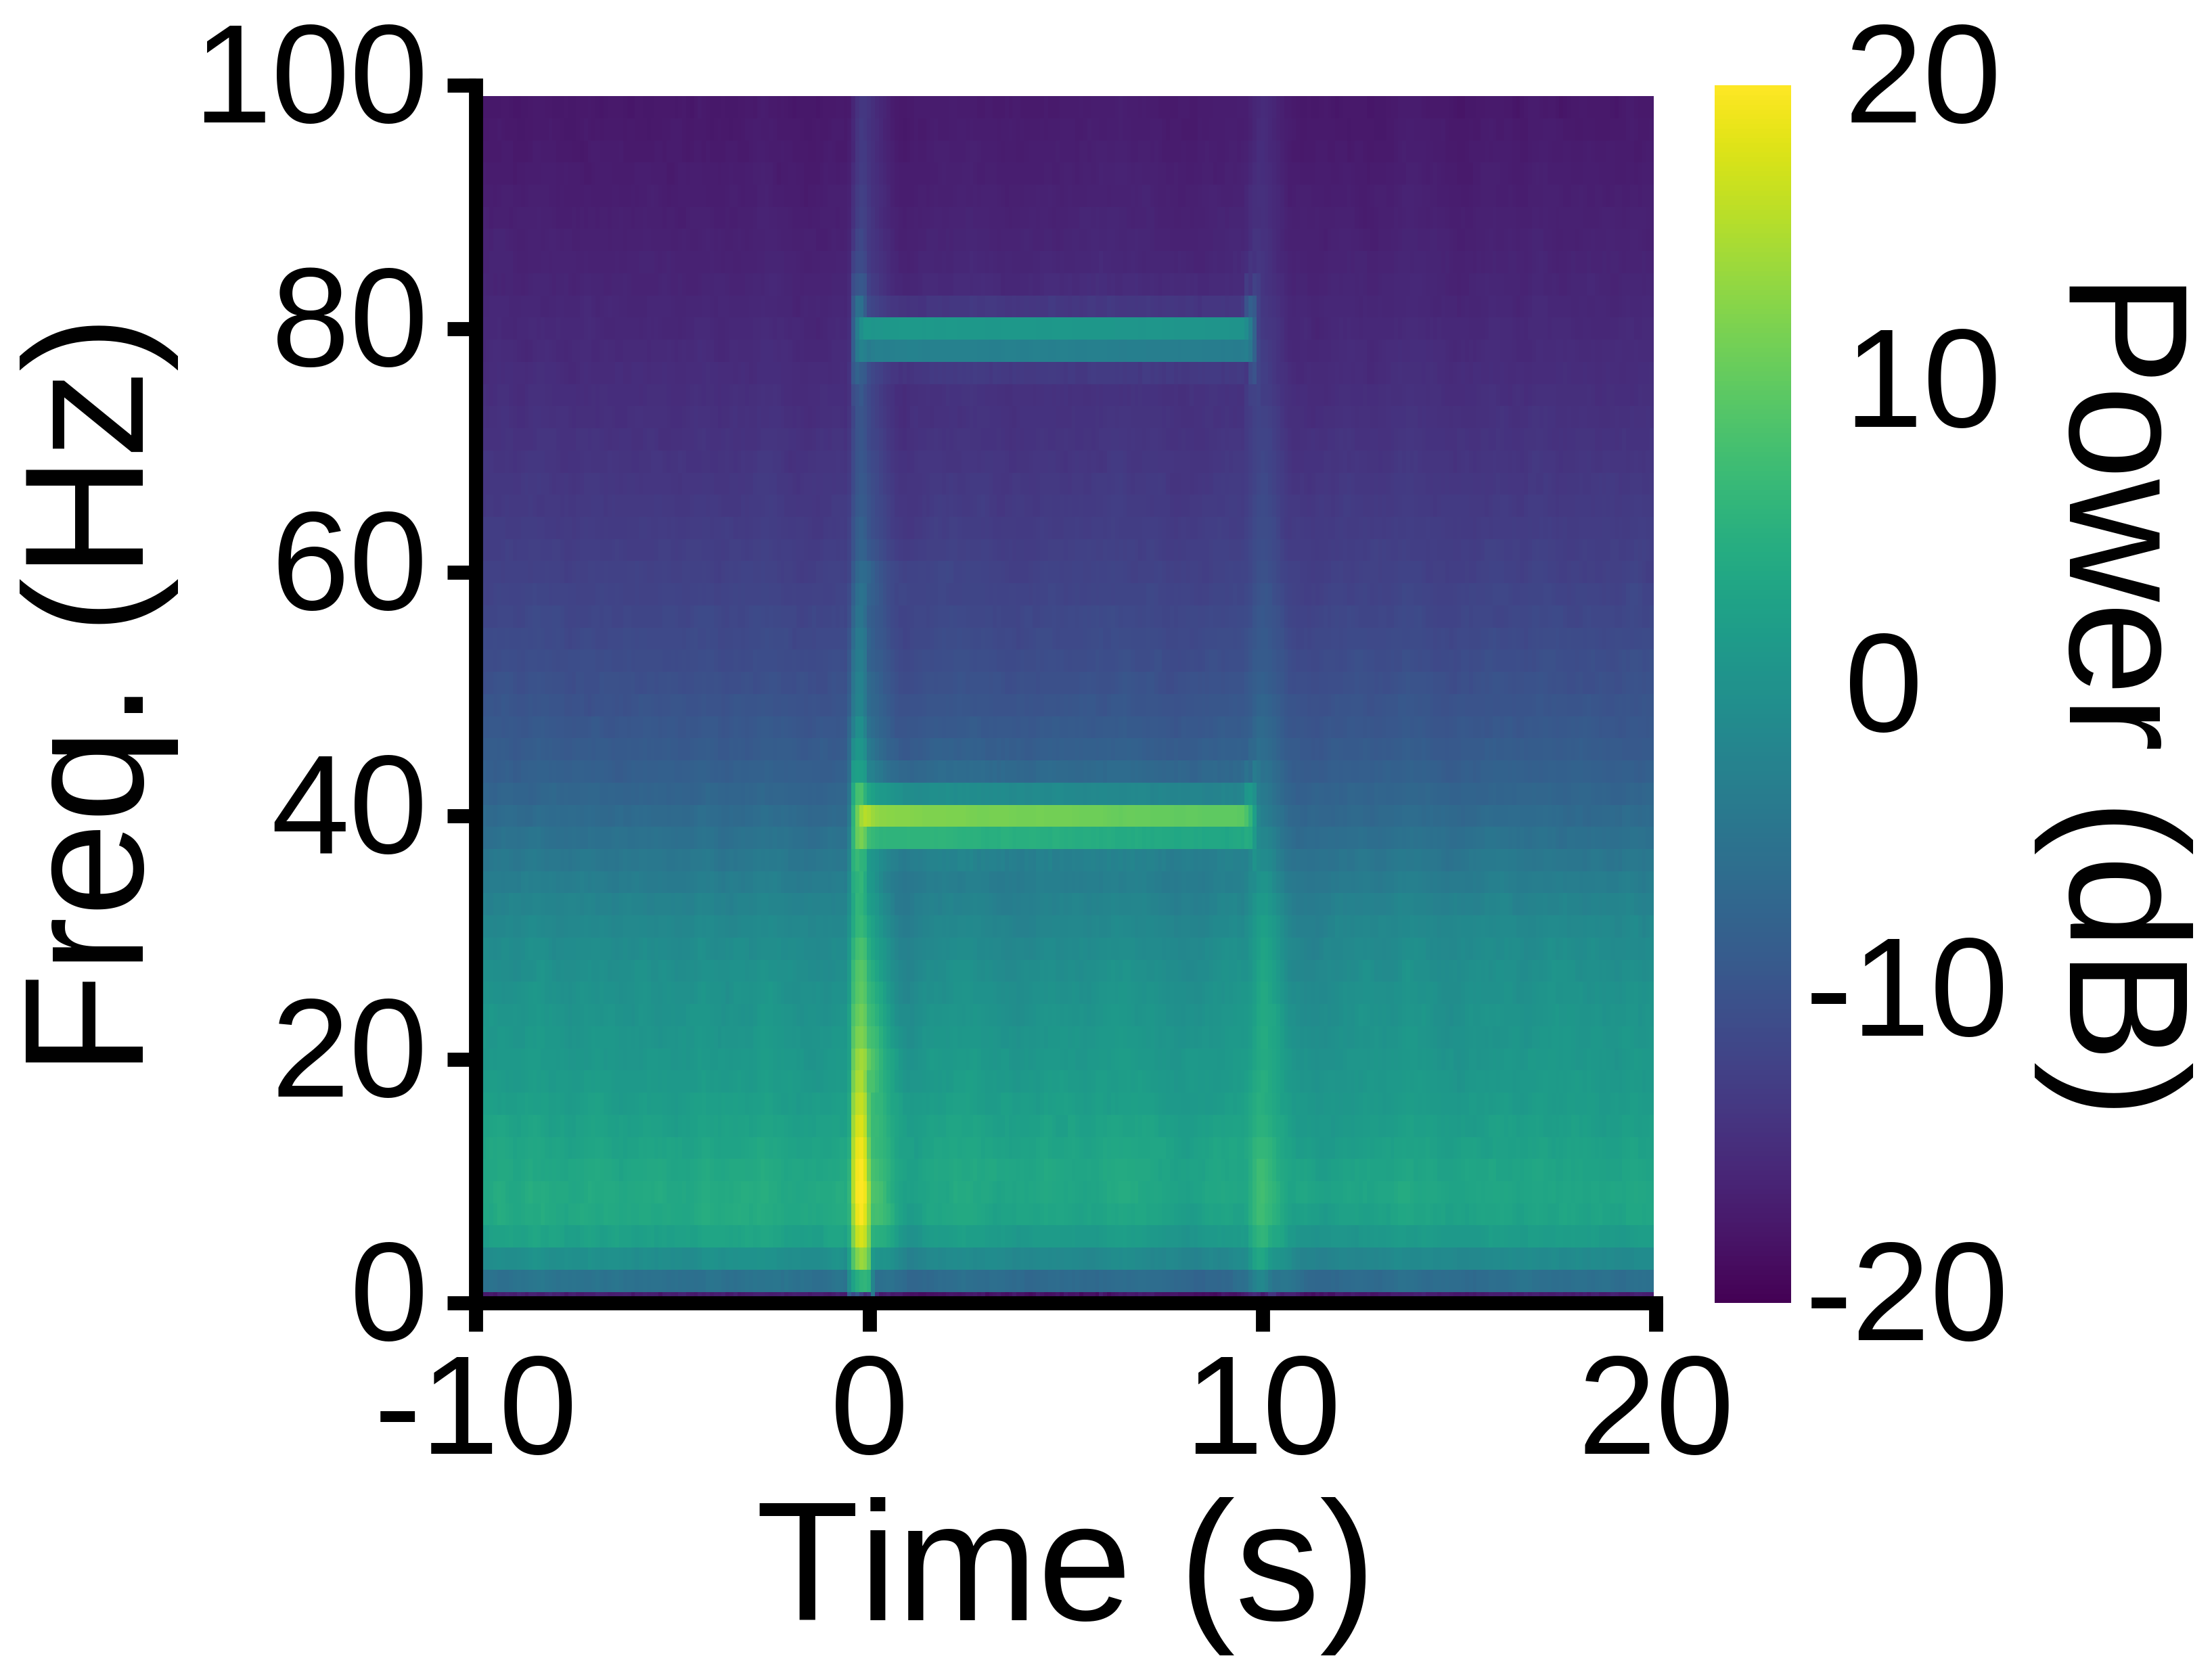

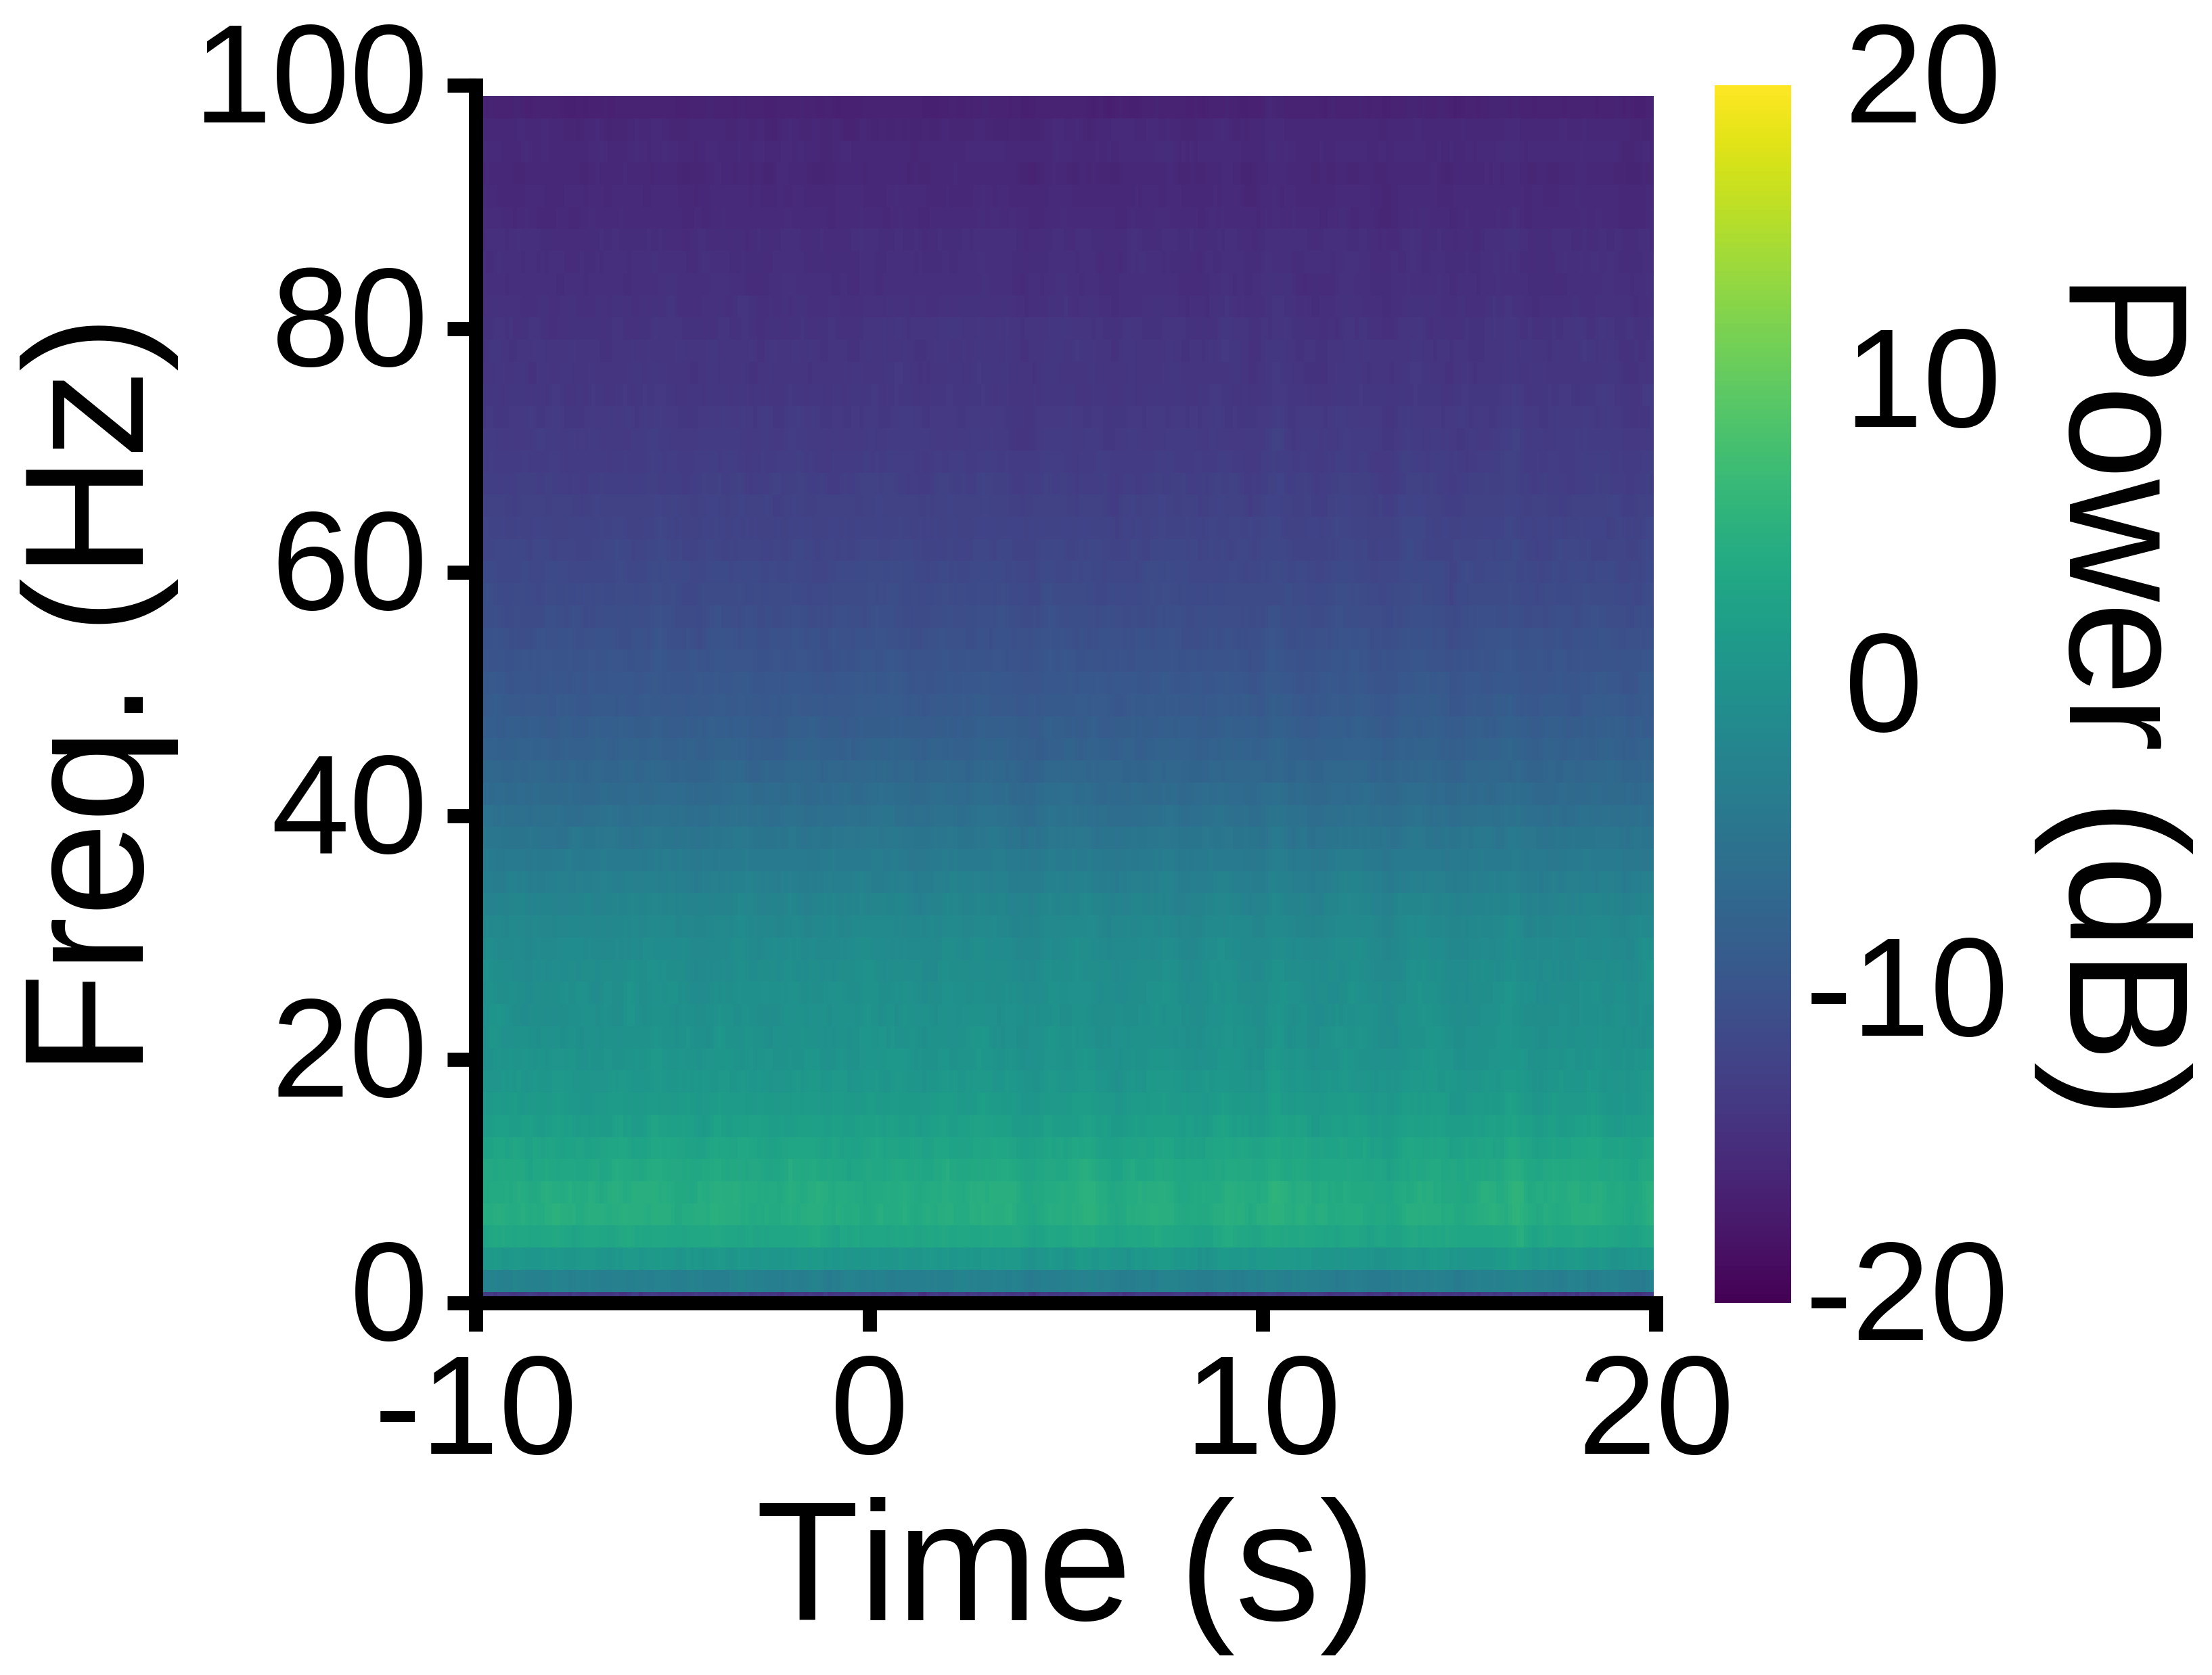

In [8]:
# be sure to define the group and set appropriate data/paradigm parameters
plot_data(prj, 'group-folder-name',
#           Cxls ='previous-analysis-Excel-file-path',  #use this to edit plot quickly without redoing the analysis
          dshape = 16, x_ticks = 100, vmin = -20, vmax = 20, z_bins = 5)

# function to get group-level PSD data from project object
## in this version, the data is cut and concatenated from Neuroexplorer output format (grouped by recording channel) into event-related epoch time windows, then collapsed in the time axis according to the number of periods in each epoch (e.g. baseline, event, post-event), and finally the event data is subtracted from baseline to represent power change.
## Set periods and "buffer" time window for fourier transform to match your dataset. if the data does not have 3 periods and the first 2 are not your baseline and event, then this code will have to be modified


In [9]:
def get_psd(prj, group, cond, dshape, periods = 3, buffer = 6):
    new_prj = prj(2, 'subproject-folder-name', group, cond, ext='.xlsx')
    df = pd.DataFrame()
    for f, finfo in new_prj:
        dft = pd.DataFrame()
        dff = pd.read_excel(finfo.Abspath, index_col = None).dropna()
        chunk_size = int(dff.shape[1] / dshape)
        period = chunk_size/periods
        p = 0
        for col in range(0, dff.shape[1], chunk_size):
            bl_start = col
            bl_end = col+period-6
            stim_start = col + period + buffer
            stim_end = col + 2*period - buffer
            dff_bl = dff.iloc[:,bl_start:bl_end].mean(axis=1)
            dff_std = dff.iloc[:,bl_start:bl_end].std(axis=1)
            dff_stim = dff.iloc[:,stim_start:stim_end].mean(axis=1)

            dft[p] = dff_stim - dff_bl
            p=p + 1
            

        df = pd.concat([df, dft], axis=1, ignore_index=True)

    return df


# Plot formatting helper function

In [10]:
def tsplot(df, add_plot=None, figsize=None, xlim=None, ylim=None, xlabel=None, ylabel=None,
               label_size=None, tick_size=None, title=None, title_size=None, err=0, **kwargs):
        """

        :param df:
        :param figsize:
        :param xlim:
        :param ylim:
        :param xlabel:
        :param ylabel:
        :param label_size:
        :param tick_size:
        :param title:
        :param title_size:
        :param err: 0 = standard deviation, 1 = standard error
        :param kwargs:
        :return:
        """
        if not add_plot:
            fig, axes = plt.subplots(1,1,figsize=figsize)
        else:
            fig, axes = add_plot
        fig.patch.set_facecolor('white')
        axes.spines['top'].set_visible(False)
        axes.spines['right'].set_visible(False)
        for axis in ['top','bottom','left','right']:
              axes.spines[axis].set_linewidth(5)
        if xlim:
            axes.set_xlim(xlim)
        if ylim:
            axes.set_ylim(ylim)
        if title:
            axes.set_title(title, size=title_size)
        if xlabel:
            axes.set_xlabel(xlabel, size=label_size)
        else:
            axes.set_xlabel('Time (s)', size=label_size)
        if ylabel:
            axes.set_ylabel(ylabel, size=label_size)
        else:
            axes.set_ylabel('Responses', size=label_size)

        tlen = int(tick_size/5)
        
        axes.tick_params(labelsize=tick_size, direction='out', top='off', right='off', width = 5, length = tlen)
        grey2 = [colors.to_rgba('grey',.1)]
        
        if err == 1:
            sns.tsplot(df.T.values, err_style='sterr_band', ax=axes,  **kwargs)
            
        elif err == 0:
            sns.tsplot(df.T.values, err_style=None, ax=axes, **kwargs)
        else:
            sns.tsplot(df.T.values, err_style='unit_traces', err_palette = grey2, err_kws = {'alpha':.15}, ax=axes, **kwargs)
        return fig, axes

# Plotting function for event-related changes in PSD for 2 conditions (e.g. experimental and control), after plotting, the power change at an apriori event-related peak frequency is extracted for each group for straightforward comparisons

## set experimental parameters here or when calling the function

In [11]:
def plot_psd(prj, group, first_cond = 'ChR2', second_cond = 'eYFP', Cxls= None, Exls= None, dshape = 16, figsize=[7.5,7.5], label_size=60, err=1, title_size=60, n_tick_a = 5, ylim = [-5,15],
              tick_size=50, ylabel='Power (dB)', xlabel='Frequency (Hz)', n_tick_b=11, avg_start = -1,
              avg_end = 1, linewidth = 5, fstart=18,fend = 98, peakloc = 22):
                       
    if Cxls:
        data_ChR2=pd.ExcelFile(Cxls)
        data_ChR2=pd.ExcelFile.parse(data_ChR2, header = None, index_col = None)
    else:
        data_G = get_psd(prj, group, first_cond, dshape)
        data_ChR2=data_G.reset_index(drop = True)
        data_ChR2.to_excel('{}_{}_{}.xlsx'.format(group, first_cond, 'PSD'), index = None, header = None)
    if Exls:
        data_eYFP=pd.ExcelFile(Exls)
        data_eYFP=pd.ExcelFile.parse(data_eYFP, header = None, index_col = None)
    else:
        data_HbT = get_psd(prj, group, second_cond, dshape)
        data_eYFP=data_HbT.reset_index(drop = True)
        data_eYFP.to_excel('{}_{}_{}.xlsx'.format(group, second_cond, 'PSD'), index = None, header = None)
                   
    ax1 = tsplot(data_eYFP, color = 'tab:grey', alpha =1, err=err, figsize=figsize,label_size=label_size, title_size=title_size,
                         tick_size=tick_size, ylabel= 'Power change (dB)', xlabel=xlabel, ylim = ylim, linewidth=linewidth)
    ax1 = tsplot(data_ChR2, color = 'tab:red', alpha =1, err=err, figsize=figsize,label_size=label_size, title_size=title_size,
                         tick_size=tick_size, ylabel= 'Power change (dB)', xlabel=xlabel, ylim = ylim, linewidth=linewidth, add_plot=ax1)
   
    ax1[1].set_xlim(right = data_ChR2.shape[0])
    ax1[1].yaxis.set_major_locator(ticker.MultipleLocator(n_tick_a))
    ax1[1].xaxis.set_major_locator(ticker.MultipleLocator(n_tick_b))
    ax1[1].xaxis.set_major_formatter(FuncFormatter(numfmt))
    ylim_neg = ax1[1].get_ylim()
    ax1[1].add_patch(patches.Rectangle((peakloc + avg_start, ylim_neg[0]), avg_end - avg_start, abs(ylim_neg[0])
                                        +abs(ylim_neg[1]), color = 'g', alpha = 0.09))   
    
    try:
        ap = data_eYFP.plot(cmap='summer',legend=False, figsize=figsize, linewidth=linewidth/4)
        ap.set_prop_cycle(pyplot.rcParams["axes.prop_cycle"])
        Gdf = DataFrame()

        Gcsvdf = DataFrame(data=None, columns=['Name','StimAVG', 'StimX'])

        styles = {}
        count=0
        for name in data_eYFP.columns:
            list = data_eYFP[name].tolist();

            stimavg = sum(list[peakloc+avg_start:peakloc+avg_end]) / len(list[peakloc+avg_start:peakloc+avg_end])

            stimx= peakloc

            newcol = []
            newcol = newcol + [NaN]*(data_eYFP.count()[0]);

            newcol[stimx] = stimavg

            Gdf[int(name)] = newcol

            Gcsvdf = Gcsvdf.append({'Name':name, 'StimAVG': stimavg, 'StimX':stimx}, ignore_index=True);

        Gcsvdf.to_csv('{}_{}_{}.csv'.format(group, second_cond, 'PSDStimAVG'))


        a = Gdf.plot(marker= 7, color='black', legend=False, ax = ap)

        ap.add_patch(patches.Rectangle((58-0.5, -50), 5, 100, color = 'b', alpha = 0.09)) 

        pyplot.show()
    except:
        pass
    
    ap1 = data_ChR2.plot(cmap='summer',legend=False, figsize=figsize, linewidth=linewidth/4)
    ap.set_prop_cycle(pyplot.rcParams["axes.prop_cycle"])
    Gdf1 = DataFrame()
    
    Gcsvdf1 = DataFrame(data=None, columns=['Name','StimAVG', 'StimX'])
    
    styles = {}
    count=0
    for name in data_ChR2.columns:
        list = data_ChR2[name].tolist();
        
        stimavg = sum(list[peakloc+avg_start:peakloc+avg_end]) / len(list[peakloc+avg_start:peakloc+avg_end])
        
        stimx= peakloc
        
        newcol = []
        newcol = newcol + [NaN]*(data_ChR2.count()[0]);
        
        newcol[stimx] = stimavg

        Gdf1[int(name)] = newcol

        Gcsvdf1 = Gcsvdf1.append({'Name':name, 'StimAVG': stimavg, 'StimX':stimx}, ignore_index=True);

    Gcsvdf1.to_csv('{}_{}_{}.csv'.format(group, first_cond, 'PSDStimAVG'))
      
    a1 = Gdf1.plot(marker= 7, color='black', legend=False, ax = ap1)

    ap1.add_patch(patches.Rectangle((58-0.5, -50), 5, 100, color = 'b', alpha = 0.09))   
    

  
    pyplot.show()
    
    return ax1, ap, ap1

## Optional function to convert y axis (frequency) values

In [12]:
def numfmt(x, pos): # custom formatter function
    s = '{:.0f}'.format(x  * 1.8181818)
    return s

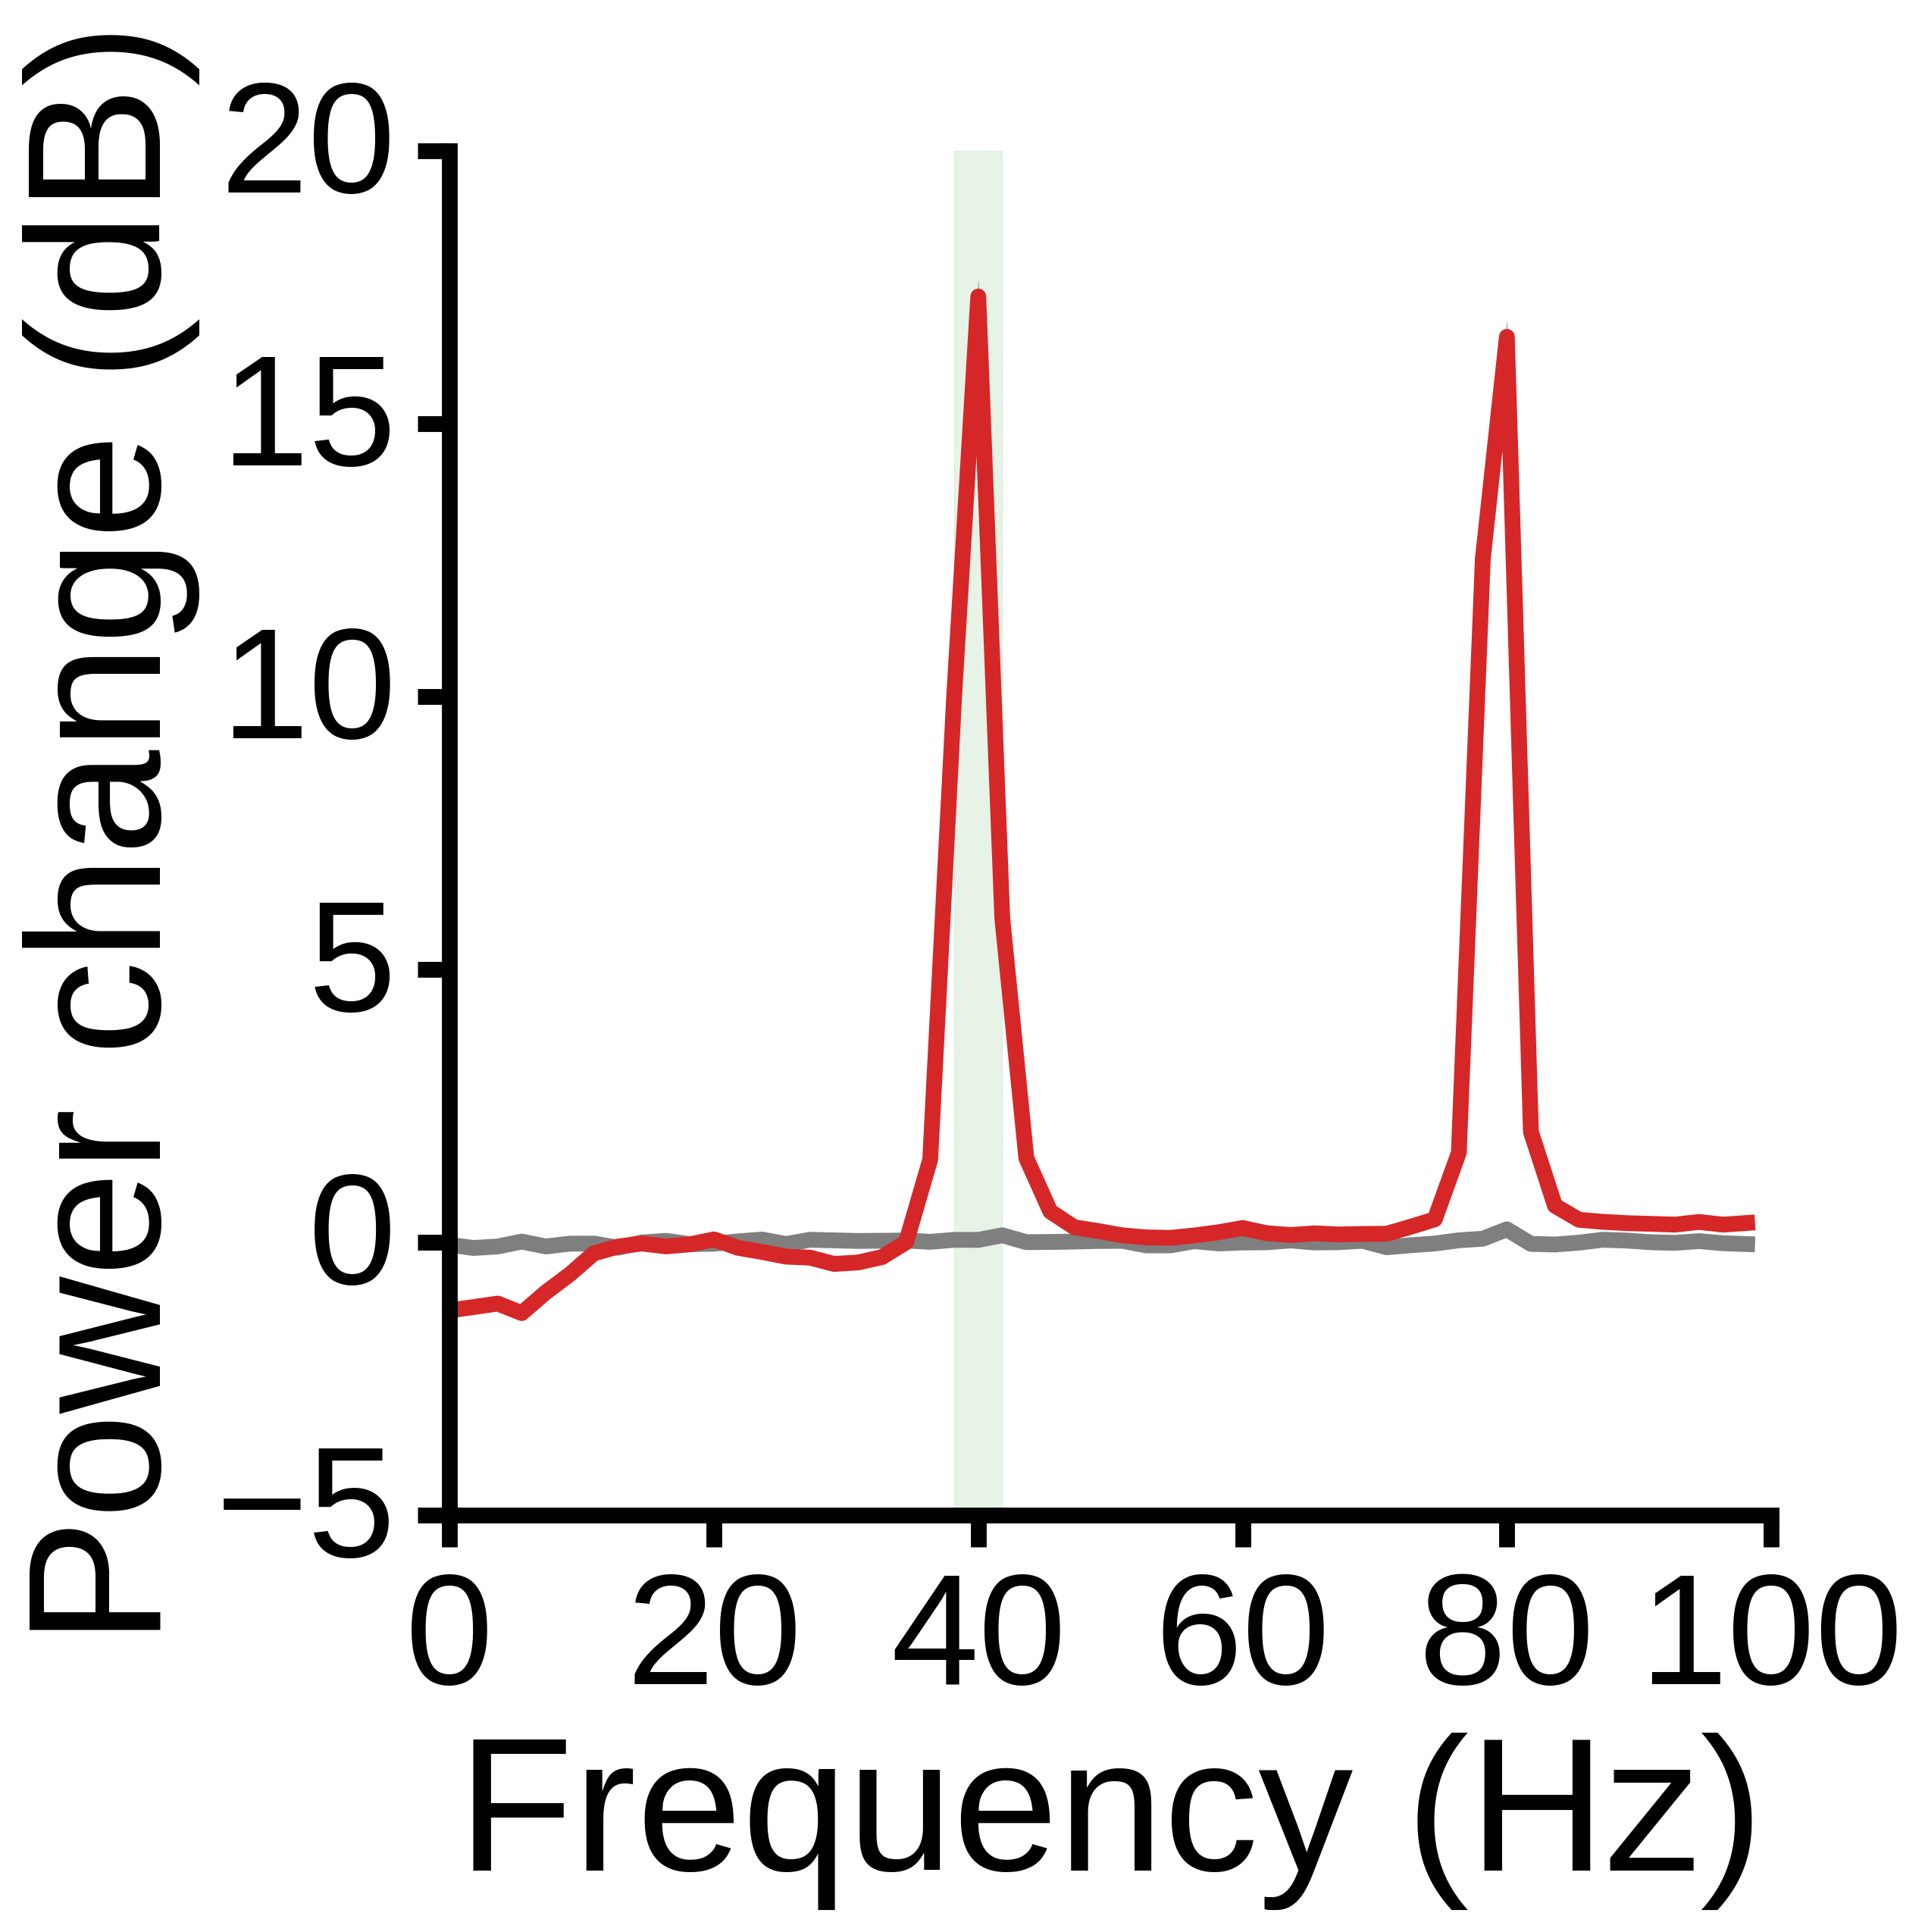

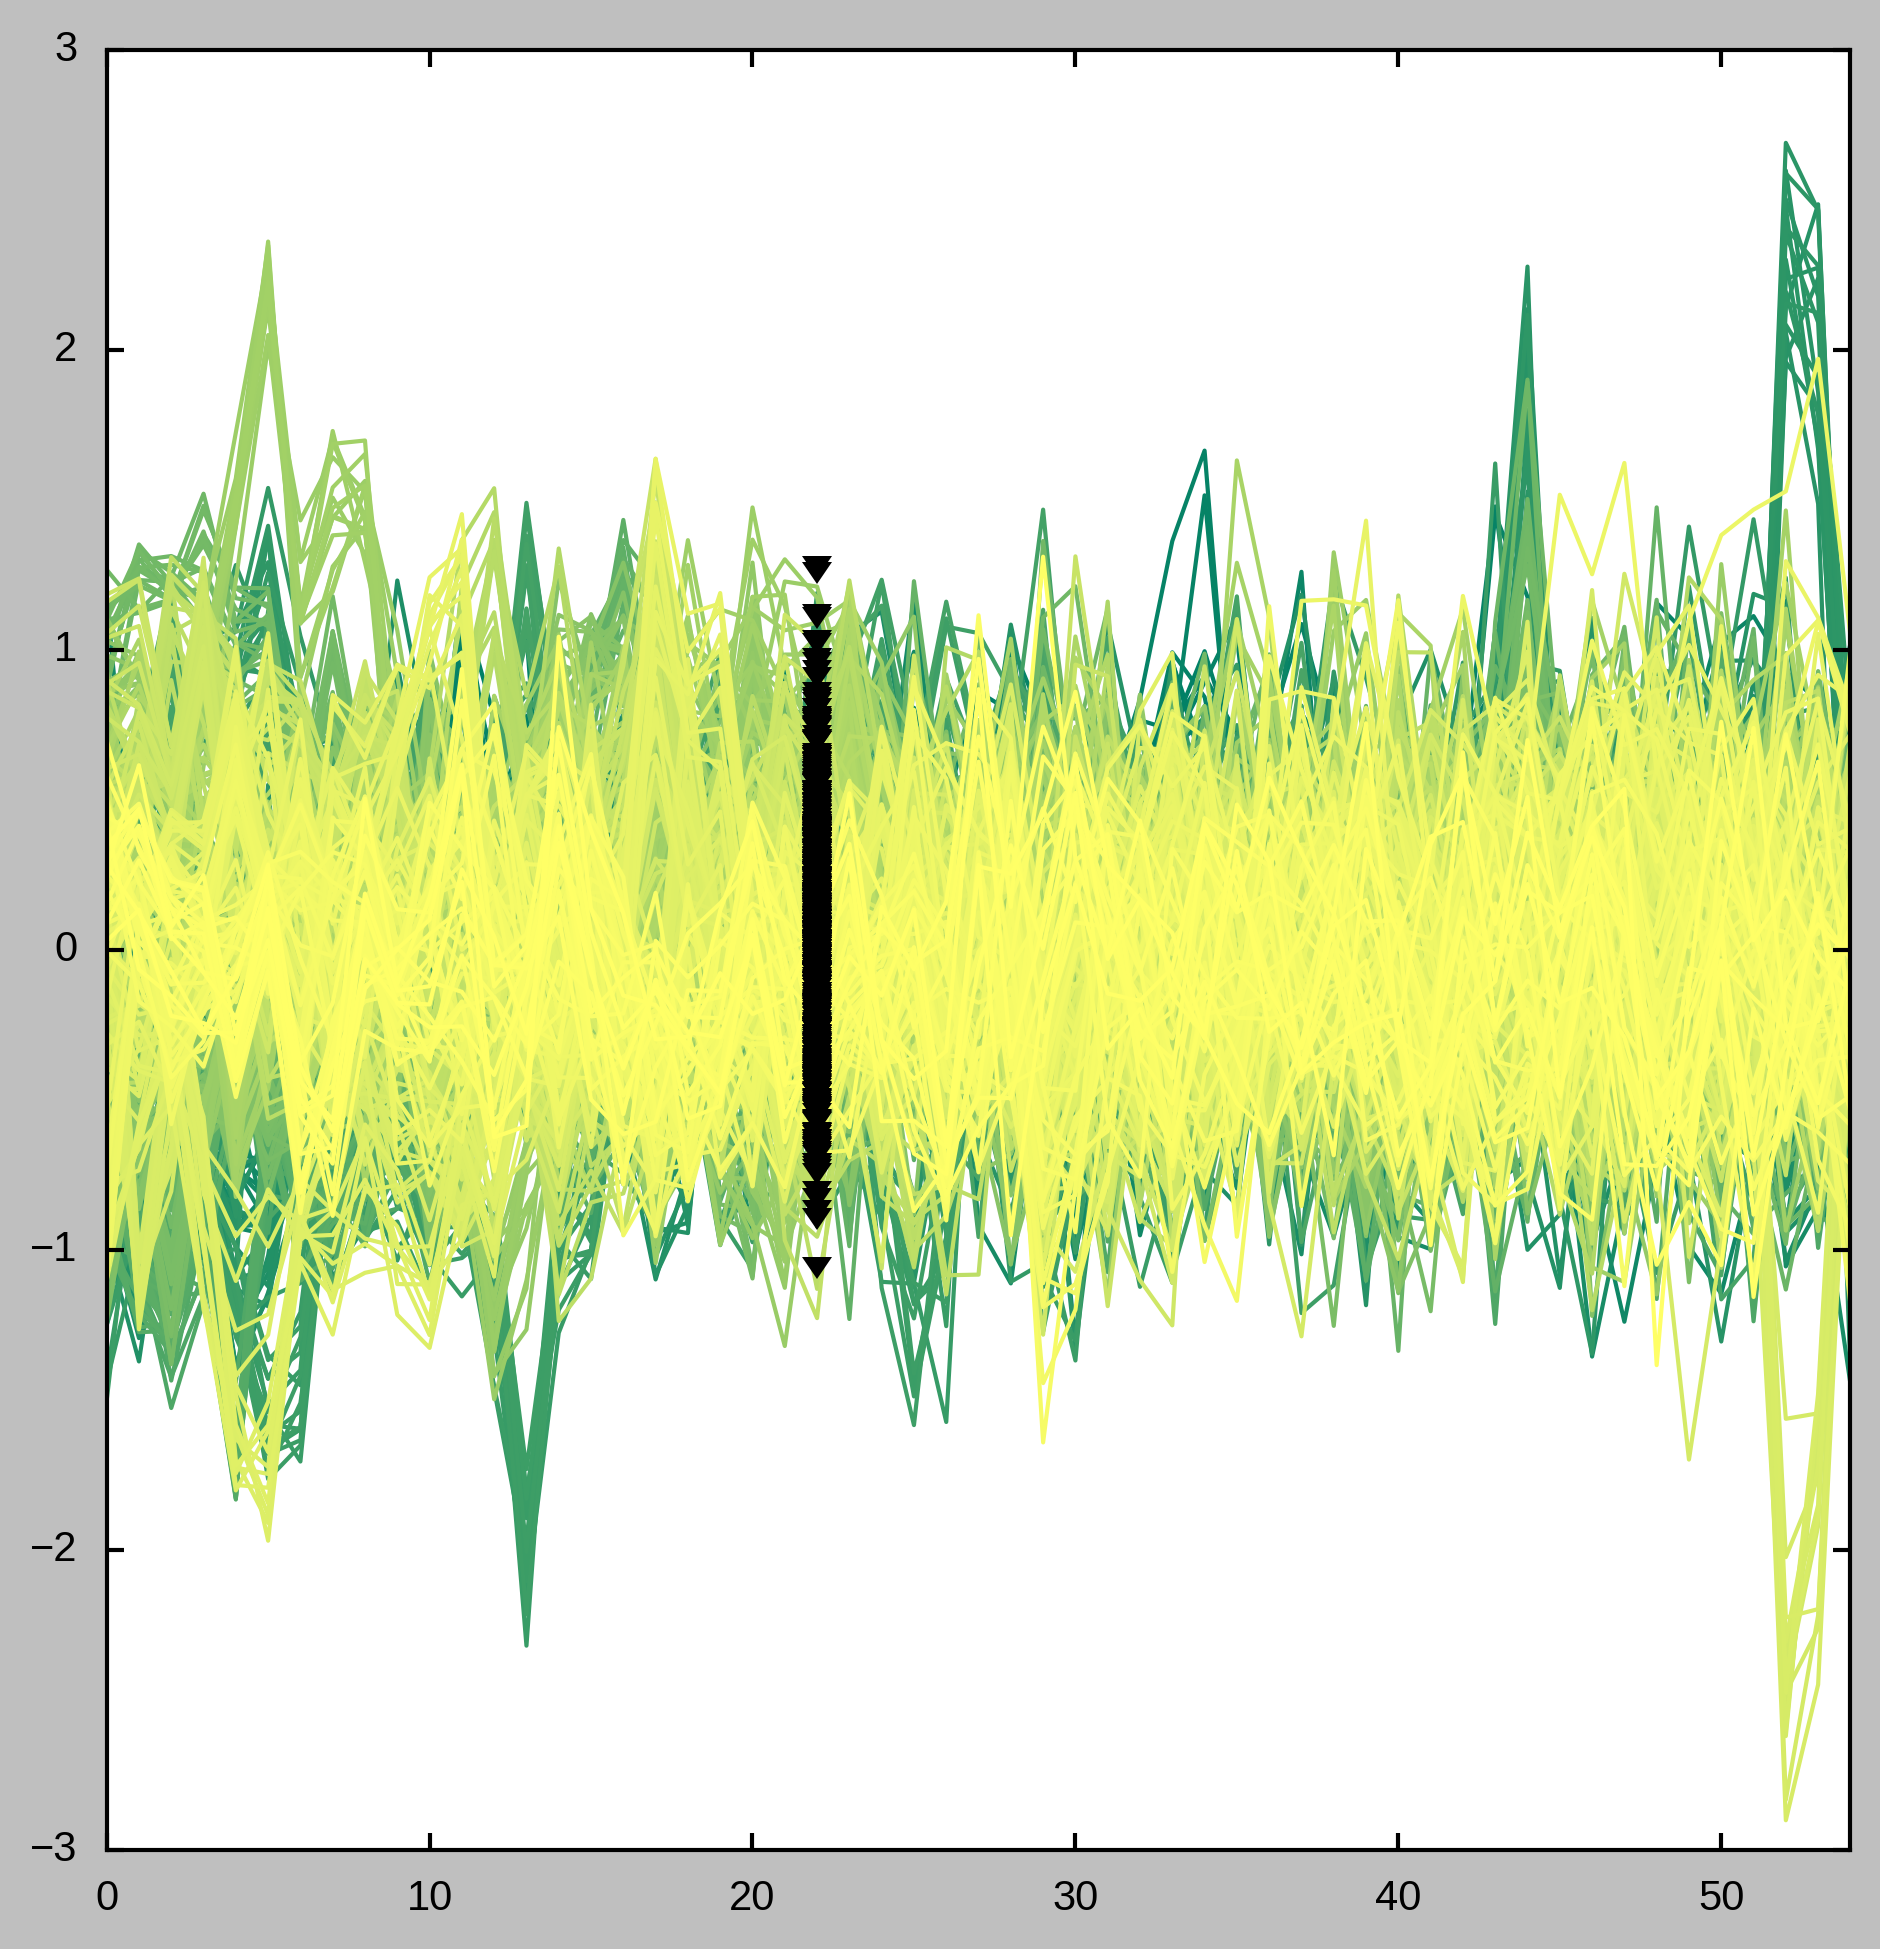

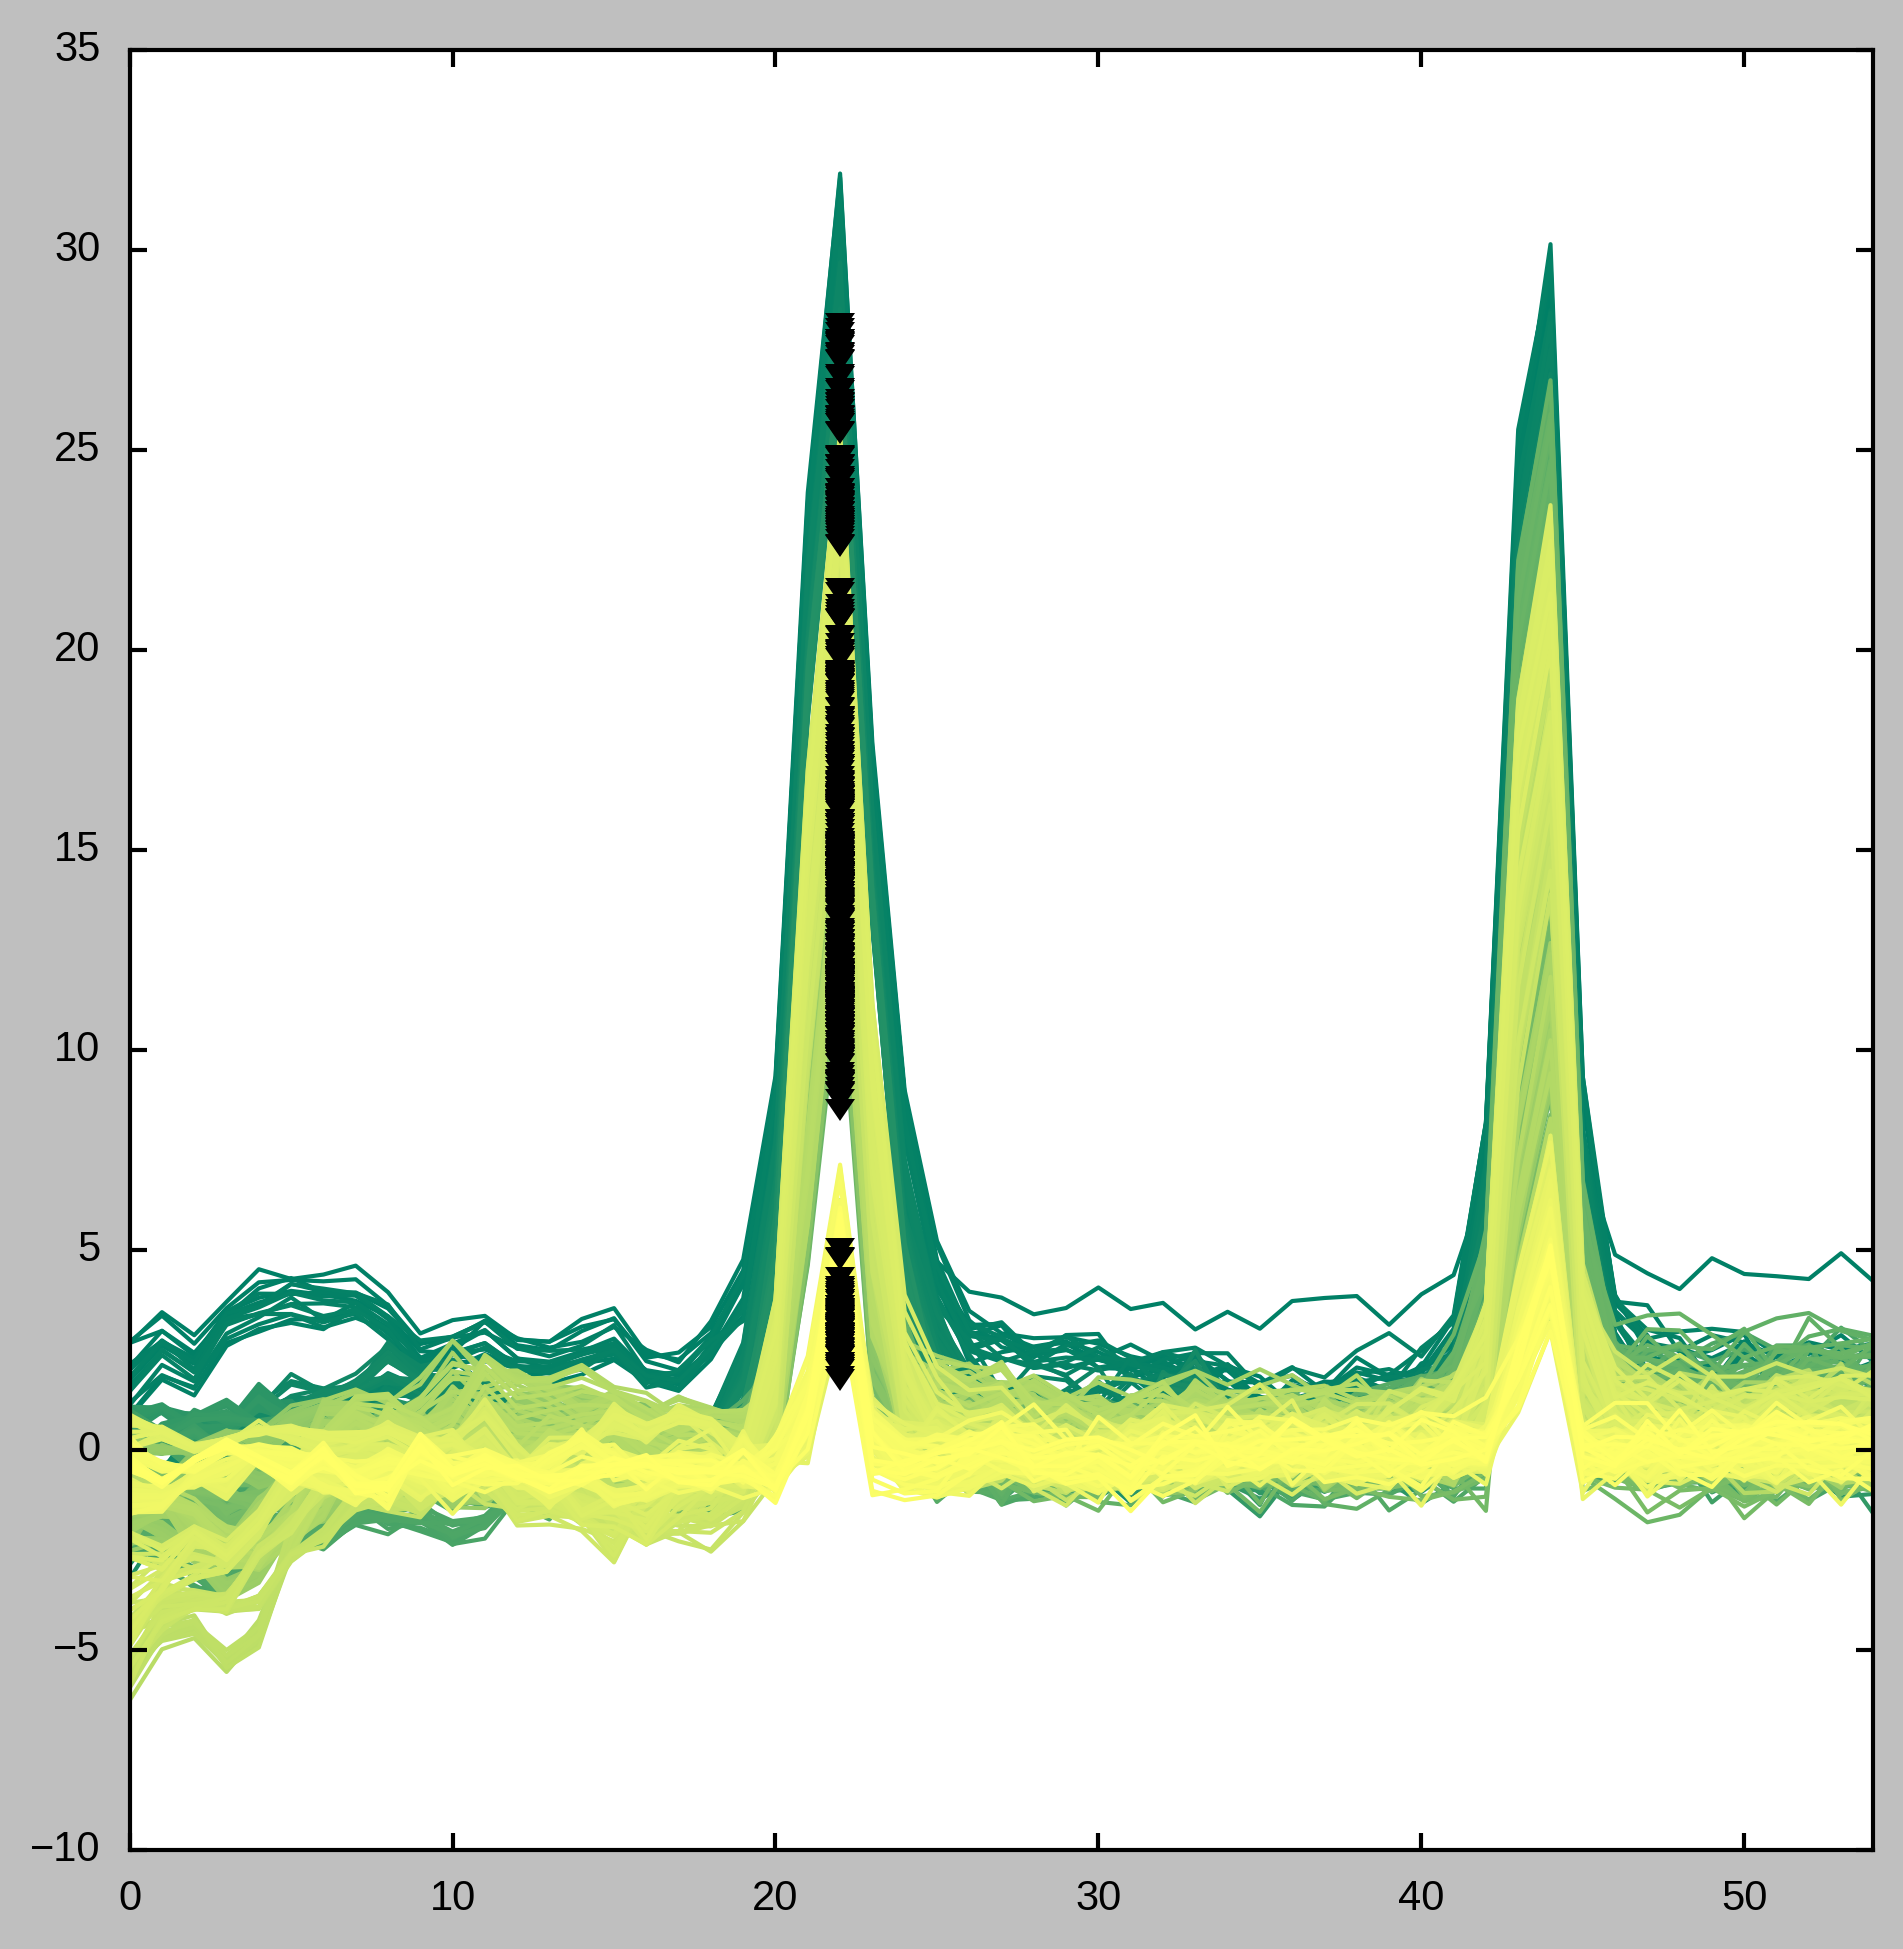

((<matplotlib.figure.Figure at 0x7fbec0791bd0>,
  <matplotlib.axes._subplots.AxesSubplot at 0x7fbe66261510>),
 <matplotlib.axes._subplots.AxesSubplot at 0x7fbe61ce6490>)

In [13]:
plot_psd(prj, 'group-folder-name', 
#          Cxls ='first-group-previous-analysis-Excel-file-path',Exls ='secod-group-previous-analysis-Excel-file-path',  #use this to edit plot quickly without redoing the analysis
          dshape = 16, n_tick_a = 5, ylim = [-5,20])